In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import ks_2samp
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
fp = "data/spectral_templates_data_version_july15.h5"

singles_flux = pd.read_hdf(fp, key="singles_flux")
binaries_flux = pd.read_hdf(fp, key="binaries_flux")

singles_noise = pd.read_hdf(fp, key="singles_noise")
binaries_noise = pd.read_hdf(fp, key="binaries_noise")

singles_difference_spectrum = pd.read_hdf(fp, key="singles_difference_spectrum")
binaries_difference_spectrum = pd.read_hdf(fp, key="binaries_difference_spectrum")

In [3]:
singles_flux.shape, singles_noise.shape, singles_difference_spectrum.shape

((436, 443), (417, 443), (253, 443))

In [4]:
singles_flux_dedup = singles_flux.drop_duplicates(subset="object_name")
singles_noise_dedup = singles_noise.drop_duplicates(subset="object_name")
singles_difference_spectrum_dedup = singles_difference_spectrum.drop_duplicates(
    subset="object_name"
)

singles_merged = singles_noise_dedup.merge(
    singles_difference_spectrum_dedup, on="object_name", suffixes=("_noise", "_diff")
)
singles_merged = singles_merged.merge(singles_flux_dedup, on="object_name")
singles_merged = singles_merged.drop(
    columns=["spectral_type_noise", "spectral_type_diff"]
)
singles_merged.head()

,flux_0_noise,flux_1_noise,flux_2_noise,flux_3_noise,flux_4_noise,flux_5_noise,flux_6_noise,flux_7_noise,flux_8_noise,flux_9_noise,...,flux_432,flux_433,flux_434,flux_435,flux_436,flux_437,flux_438,flux_439,flux_440,spectral_type
0,0.005428,0.005659,0.005690,0.005850,0.005947,0.005946,0.005955,0.005882,0.005778,0.005658,...,0.218047,0.215337,0.215931,0.205811,0.202409,0.200154,0.205162,0.200159,0.202379,M6.0
1,0.034344,0.035064,0.033996,0.034829,0.033618,0.032844,0.025544,0.027487,0.029544,0.030125,...,0.230284,0.206600,0.201257,0.200105,0.205926,0.200983,0.208295,0.216014,0.224778,M6.0
2,0.047652,0.030335,0.028437,0.038433,0.034301,0.022394,0.028870,0.037834,0.029561,0.026788,...,0.226817,0.229087,0.207245,0.208434,0.211384,0.202791,0.202994,0.216542,0.211448,M7.0
3,0.011901,0.019064,0.012164,0.012932,0.009753,0.009956,0.008267,0.011325,0.012165,0.014767,...,0.156008,0.157152,0.158078,0.160547,0.151297,0.149293,0.144747,0.160000,0.148471,M6.0
4,0.028819,0.027557,0.027452,0.026742,0.027310,0.026695,0.027350,0.026848,0.025786,0.024884,...,0.254465,0.241278,0.246377,0.241199,0.262611,0.224629,0.229004,0.243447,0.241497,M6.0


In [5]:
binaries_merged = binaries_noise.merge(
    binaries_difference_spectrum, on="object_name", suffixes=("_noise", "_diff")
)
binaries_merged = binaries_merged.merge(binaries_flux, on="object_name")
binaries_merged = binaries_merged[
    binaries_merged["primary_type"] > binaries_merged["secondary_type"]
    ]
binaries_merged_no_ps = binaries_merged.drop(columns=["primary_type", "secondary_type"])
binaries_merged_no_ps = binaries_merged_no_ps.rename(columns={"system_type": "spectral_type"})
binaries_merged_no_ps.head()

,flux_0_noise,flux_1_noise,flux_2_noise,flux_3_noise,flux_4_noise,flux_5_noise,flux_6_noise,flux_7_noise,flux_8_noise,flux_9_noise,...,flux_432,flux_433,flux_434,flux_435,flux_436,flux_437,flux_438,flux_439,flux_440,spectral_type
194,0.025564,0.025066,0.024419,0.023798,0.023288,0.023100,0.023100,0.022864,0.022703,0.022501,...,0.342569,0.327296,0.329594,0.332689,0.323894,0.311897,0.314376,0.313909,0.319669,22.0
505,0.021880,0.021989,0.021494,0.021660,0.021027,0.020899,0.018598,0.019081,0.019170,0.019201,...,0.299782,0.284738,0.284312,0.282232,0.278920,0.275603,0.277821,0.282118,0.279295,19.0
510,0.007891,0.007888,0.007635,0.007660,0.007616,0.007712,0.007597,0.007608,0.007472,0.007309,...,0.316078,0.305937,0.298460,0.292649,0.288328,0.292961,0.292411,0.293604,0.289886,21.0
704,0.034344,0.035064,0.033996,0.034829,0.033618,0.032844,0.025544,0.027487,0.029544,0.030125,...,0.230284,0.206600,0.201257,0.200105,0.205926,0.200983,0.208295,0.216014,0.224778,16.0
755,0.034344,0.035064,0.033996,0.034829,0.033618,0.032844,0.025544,0.027487,0.029544,0.030125,...,0.230284,0.206600,0.201257,0.200105,0.205926,0.200983,0.208295,0.216014,0.224778,16.0


In [6]:
binaries_merged_no_ps["single"] = 0
singles_merged["single"] = 1
df = pd.concat([binaries_merged_no_ps, singles_merged]).reset_index(drop=True)
df = df.sample(frac=1)

type_map = {"M": 10, "L": 20, "T": 30}


def condition(x):
    if type(x) == str:
        return int(x[1]) + type_map[x[0]]
    else:
        return x


df["spectral_type"] = df["spectral_type"].apply(condition)
df.head()

,flux_0_noise,flux_1_noise,flux_2_noise,flux_3_noise,flux_4_noise,flux_5_noise,flux_6_noise,flux_7_noise,flux_8_noise,flux_9_noise,...,flux_433,flux_434,flux_435,flux_436,flux_437,flux_438,flux_439,flux_440,spectral_type,single
646,0.003591,0.003439,0.003526,0.003882,0.004058,0.004203,0.004220,0.004264,0.004738,0.004807,...,0.351962,0.347226,0.340382,0.337055,0.339132,0.339610,0.338913,0.337870,24.0,0
2197,0.011932,0.012045,0.011865,0.011920,0.011721,0.012001,0.011770,0.011728,0.011222,0.011116,...,0.258551,0.259702,0.250690,0.247691,0.244379,0.254603,0.252281,0.247176,19.0,1
2174,0.012238,0.012046,0.011745,0.011680,0.011668,0.011490,0.010576,0.010565,0.010846,0.010346,...,0.268458,0.259801,0.253817,0.250789,0.252006,0.256773,0.258140,0.256982,19.0,1
1177,0.018182,0.007169,0.011133,0.021069,0.017189,0.016862,0.007904,0.011596,0.020174,0.016349,...,0.441302,0.426602,0.428107,0.420892,0.425011,0.429923,0.422048,0.424256,28.0,0
2120,0.060024,0.067399,0.050768,0.065469,0.035490,0.022637,0.060846,0.039452,0.044538,0.023067,...,0.232762,0.225982,0.249831,0.234588,0.232952,0.266016,0.228038,0.263454,30.0,0


In [7]:
df.shape

(2373, 1326)

In [8]:
df["single"].value_counts(normalize=True)

0    0.898862
1    0.101138
Name: single, dtype: float64

In [9]:
pct_single = round(len(singles_merged) / (len(singles_merged) + len(binaries_merged)) * 100, 2)
print(f"Singles are {pct_single}% of the dataset.")

Singles are 10.11% of the dataset.


In [10]:
X = df.drop(columns=["single", "object_name"])
y = df["single"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
test_pred = clf.predict(X_test)
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       534
           1       0.12      0.07      0.09        60

    accuracy                           0.86       594
   macro avg       0.51      0.51      0.50       594
weighted avg       0.82      0.86      0.84       594



In [11]:
# Under-sample binaries in training set
X_train_idx = X_train.index
df_train = df.iloc[X_train_idx]
binary_idx = df_train[df_train["single"] == 0].index
random_idx = np.random.choice(binary_idx, df_train["single"].sum(), replace=False)
binaries_train = df_train.loc[random_idx]

singles_train = df_train[df_train["single"] == 1]

df_train = pd.concat([singles_train, binaries_train]).reset_index(drop=True)
df_train = df_train.sample(frac=1)

X_train = df_train.drop(columns=["single", "object_name"])
y_train = df_train["single"]

In [473]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
test_pred = clf.predict(X_test)
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.99      0.60      0.75       534
           1       0.21      0.93      0.34        60

    accuracy                           0.64       594
   macro avg       0.60      0.77      0.55       594
weighted avg       0.91      0.64      0.71       594



In [36]:
def filter_spectral_type(min_type, max_type, split_single=True):
    df_single = df[df["single"] == 1]
    df_binary = df[df["single"] == 0]

    if split_single:
        df_single_filtered = df_single[
            (df_single["spectral_type"] >= min_type)
            & (df_single["spectral_type"] <= max_type)
            ]
        print(
            f"Number of singles with type {min_type}-{max_type}: {len(df_single_filtered)}"
        )
    else:
        df_single_filtered = df_single
        print(
            f"Number of singles: {len(df_single_filtered)}"
        )


    df_binary_filtered = df_binary[
        (df_binary["spectral_type"] >= min_type)
        & (df_binary["spectral_type"] <= max_type)
        ]
    print(
        f"Number of binaries with type {min_type}-{max_type}: {len(df_binary_filtered)}\n"
    )

    _df_filtered = pd.concat([df_binary_filtered, df_single_filtered]).reset_index(
        drop=True
    )
    if "object_name" in _df_filtered.columns:
        _df_filtered = _df_filtered.drop(columns="object_name")
    return _df_filtered


def drop_features(
        _df, drop_flux=False, drop_noise=False, drop_diff=False, drop_type=False
):
    assert not all([drop_flux, drop_noise, drop_diff, drop_type])
    if drop_flux:
        _df = _df.loc[:, ~_df.columns.str.contains("flux")]
    if drop_noise:
        _df = _df.loc[:, ~_df.columns.str.contains("noise")]
    if drop_diff:
        _df = _df.loc[:, ~_df.columns.str.contains("diff")]
    if drop_type:
        _df = _df.drop(columns="spectral_type")

    return _df


def _train_test_split(_df, random_undersample=True):
    _X, _y = _df.drop(columns=["single"]), _df["single"]
    _X_train, _X_test, _y_train, _y_test = train_test_split(
        _X, _y, stratify=_y, random_state=42, test_size=0.15
    )

    if random_undersample:
        _X_train_idx = _X_train.index
        _df_train = _df.iloc[_X_train_idx]
        _binary_idx = _df_train[_df_train["single"] == 0].index

        _random_idx = np.random.choice(_binary_idx, _y_train.sum(), replace=False)
        _binaries_train = _df_train.loc[_random_idx]

        _singles_train = _df_train[_df_train["single"] == 1]
        _df_train = pd.concat([_singles_train, _binaries_train]).reset_index(drop=True)
        _df_train = _df_train.sample(frac=1)

        _X_train = _df_train.drop(columns=["single"])
        _y_train = _df_train["single"]
        print("After undersampling (training set only):")

    print(f"Number of singles: {_y_train.sum()}")
    print(f"Number of binaries: {len(_y_train) - _y_train.sum()}\n")

    return _X_train, _X_test, _y_train, _y_test


def evaluate(_clf, data, report=False):
    _X_train, _X_test, _y_train, _y_test = data
    _clf.fit(_X_train, _y_train)
    _test_pred = _clf.predict(_X_test)
    if report:
        print(classification_report(_y_test, _test_pred))
    return f1_score(_y_test, _test_pred, average="macro")


# M0-M9
print("-----M TYPES-----\n")
df_filtered = filter_spectral_type(16, 19, False)
df_filtered = drop_features(df_filtered, False, True, False, False)
X_train_M, X_test_M, y_train_M, y_test_M = _train_test_split(df_filtered, True)
scores = []
for _ in range(5):
    scores.append(
        evaluate(svm.SVC(kernel="linear"), (X_train_M, X_test_M, y_train_M, y_test_M), report=True)
    )
print(
    f"Average F1 macro score: {np.round(np.mean(scores), 2) * 100}%, +/-{np.round(np.std(scores), 2) * 100}%\n"
)

# L0-T9
print("-----L AND T TYPES-----\n")
df_filtered_2 = filter_spectral_type(25, 40, False)
df_filtered_2 = drop_features(df_filtered_2, False, True, False, False)
X_train, X_test, y_train, y_test = _train_test_split(df_filtered_2, True)
scores = []
for _ in range(5):
    scores.append(
        evaluate(svm.SVC(kernel="linear"), (X_train, X_test, y_train, y_test), report=True)
    )
print(
    f"Average F1 macro score: {np.round(np.mean(scores), 2) * 100}%, +/-{np.round(np.std(scores), 2) * 100}%\n"
)

-----M TYPES-----

Number of singles: 240
Number of binaries with type 16-19: 258

After undersampling (training set only):
Number of singles: 204
Number of binaries: 204

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        39
           1       1.00      0.78      0.88        36

    accuracy                           0.89        75
   macro avg       0.91      0.89      0.89        75
weighted avg       0.91      0.89      0.89        75

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        39
           1       1.00      0.78      0.88        36

    accuracy                           0.89        75
   macro avg       0.91      0.89      0.89        75
weighted avg       0.91      0.89      0.89        75

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        39
           1       1.00      0.78      0.88        36

    accura

<AxesSubplot:>

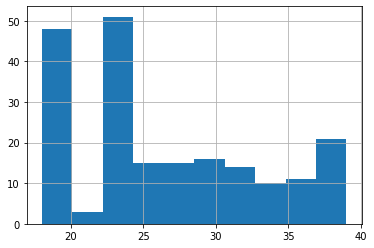

In [37]:
train_binary_idx = y_train[y_train == 0].index
train_ps_types = binaries_merged.iloc[train_binary_idx][["primary_type", "secondary_type"]]
train_ps_types["primary_type"].hist()

Text(0.5, 1.0, 'Primary Type Distribution')

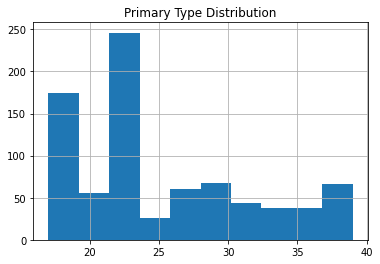

In [42]:
binary_train_idx = pd.concat([X_train_M, X_train]).index
train_ps_types = binaries_merged.iloc[binary_train_idx][["primary_type", "secondary_type"]]
train_ps_types["primary_type"].hist()
plt.title("Primary Type Distribution")

Text(0.5, 1.0, 'Secondary Type Distribution')

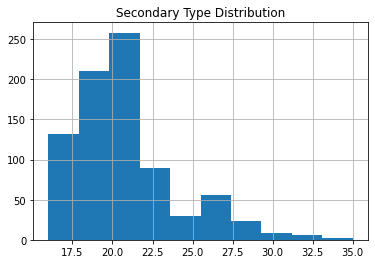

In [43]:
train_ps_types["secondary_type"].hist()
plt.title("Secondary Type Distribution")

Number of singles: 240
Number of binaries with type 16-19: 258

After undersampling (training set only):
Number of singles: 204
Number of binaries: 204

0.819672131147541
0.8285714285714286


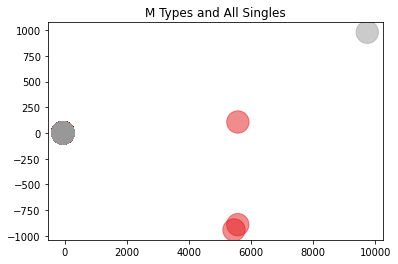

In [529]:
df_filtered = filter_spectral_type(16, 19, False)
df_filtered = drop_features(df_filtered, False, False, False, False)
X_train, X_test, y_train, y_test = _train_test_split(df_filtered, True)
clf = svm.SVC(kernel="linear")
clf.fit(X_train, y_train)
svm_preds = clf.predict(X_test)
print(f1_score(svm_preds, y_test))
print(f1_score(clf.predict(X_train), y_train))
pca = PCA(n_components=2)
Xt = pca.fit_transform(df_filtered.iloc[:, :-1])
# pca.explained_variance_ratio_
plt.scatter(Xt[:, 0], Xt[:, 1], c=df_filtered["single"], s=500, alpha=0.5, cmap="Set1");
plt.title("M Types and All Singles");

Number of singles: 240
Number of binaries with type 25-40: 795

After undersampling (training set only):
Number of singles: 204
Number of binaries: 204

0.8695652173913043
0.8115942028985508


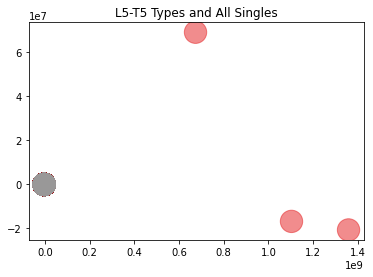

In [13]:
df_filtered = filter_spectral_type(25, 40, False)
df_filtered = drop_features(df_filtered, False, False, False, False)
X_train, X_test, y_train, y_test = _train_test_split(df_filtered, True)
clf = svm.SVC(kernel="linear")
clf.fit(X_train, y_train)
svm_preds = clf.predict(X_test)
print(f1_score(svm_preds, y_test))
print(f1_score(clf.predict(X_train), y_train))
pca = PCA(n_components=2)
Xt = pca.fit_transform(df_filtered.iloc[:, :-1])
# pca.explained_variance_ratio_
plt.scatter(Xt[:, 0], Xt[:, 1], c=df_filtered["single"], s=500, alpha=0.5, cmap="Set1");
plt.title("L5-T5 Types and All Singles");

In [ ]:
def filter_with_primary_secondary(
        binaries_df,
        singles_df,
        min_single,
        max_single,
        min_primary,
        max_primary,
        min_secondary,
        max_secondary,
):
    binaries_df["primary_type"] = binaries_df["primary_type"].apply(condition)
    binaries_df["secondary_type"] = binaries_df["secondary_type"].apply(condition)
    binaries_filtered = binaries_df[
        (binaries_df["primary_type"] >= min_primary)
        & (binaries_df["primary_type"] <= max_primary)
        & (binaries_df["secondary_type"] >= min_secondary)
        & (binaries_df["secondary_type"] <= max_secondary)
        ]
    if "single" not in binaries_filtered.columns:
        binaries_filtered.loc[:, "single"] = 0
    singles_df["spectral_type"] = singles_df["spectral_type"].apply(condition)
    singles_filtered = singles_df[
        (singles_df["spectral_type"] >= min_single)
        & (singles_df["spectral_type"] <= max_single)
        ]
    if "single" not in singles_filtered.columns:
        singles_filtered.loc[:, "single"] = 1
    binaries_filtered = binaries_filtered.drop(
        columns=["primary_type", "secondary_type"]
    ).rename(columns={"system_type": "spectral_type"})
    _df = (
        pd.concat([singles_filtered, binaries_filtered])
            .sample(frac=1)
            .reset_index(drop=True)
    )
    print(_df["single"].value_counts())
    print(_df.shape)
    if "object_name" in _df.columns:
        _df = _df.drop(columns="object_name")

    return _df

In [ ]:
df_filtered = filter_with_primary_secondary(
    binaries_df=binaries_merged,
    singles_df=singles_merged,
    min_single=0,
    max_single=40,
    min_primary=10,
    max_primary=19,
    min_secondary=16,
    max_secondary=19,
)
df_filtered = drop_features(df_filtered, False, False, True, False)
X_train, X_test, y_train, y_test = _train_test_split(df_filtered, True)

scores = []
for _ in range(5):
    scores.append(
        evaluate(RandomForestClassifier(), (X_train, X_test, y_train, y_test), report=False)
    )

print(
    f"Average F1 macro score: {np.round(np.mean(scores), 2) * 100}%, +/-{np.round(np.std(scores), 2) * 100}%\n"
)

In [ ]:
df = df_filtered
singles = df[df["single"] == 1]
binaries = df[df["single"] == 0]

singles.loc[:, singles.columns.str.contains("noise")].mean(axis=1).hist(color="black")
plt.title("Singles Differences Between Best Fit Template");

In [ ]:
binaries.loc[:, binaries.columns.str.contains("noise")].mean(axis=1).hist(color="black")
plt.title("Binaries Differences Between Best Fit Template");

In [ ]:
mean_binary_diff = binaries.loc[:, binaries.columns.str.contains("noise")].mean(axis=1)
mean_single_diff = singles.loc[:, singles.columns.str.contains("noise")].mean(axis=1)
ks_2samp(mean_binary_diff, mean_single_diff)

In [ ]:
raw = df.loc[:, ~df.columns.str.contains("noise|diff|type")]


def sample_plot(raw_df, n):
    raw_single = raw_df[raw_df["single"] == 1]
    raw_binary = raw_df[raw_df["single"] == 0]

    fig, ax = plt.subplots(1, 2, figsize=(17, 6))
    raw_single.iloc[:, :-1].sample(n).T.plot(color="blue", ax=ax[0], title="Singles")
    raw_binary.iloc[:, :-1].sample(n).T.plot(color="green", ax=ax[1], title="Binaries")


sample_plot(raw, 3)

In [ ]:
binaries_merged[binaries_merged["primary_type"] <= 19]["primary_type"].min()

In [ ]:
binaries_merged["system_type"].max()

In [ ]:
binaries_merged["primary_type"].hist()

In [ ]:
binaries_merged["secondary_type"].hist()